# Lab 16 Machine Learning Intro
#### Adam Owada and Natalie Sinner

## Chose data set and we used Pandas to create a data frame from each data set of .txt files.

In [3]:
import pandas as pd

filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


### Example of feature vector
#### Create example sentences, vectorized them, and displayed them as an array.

In [4]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [6]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

## Defined a baseline model 
### Extract Yelp sentences and labels and split them into test and training data. 

In [7]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

### Vectorized Yelp data

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

### Ran logistic regression on Yelp training data, scored it on the Yelp's test data and printed test accuracy score. 

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


### Vectorized, split and ran logistic regression on Amazon, IMDB, and Yelp training data, scored it on their test data. 

In [10]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Primer on (Deep) Neural Networks
### Import Keras and build sequential model 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Defines metrics for our training model and displays summary of model. 

In [12]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                25060     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


### Used .fit to train our model. Batch size is is responsible for how many samples we want to use in 100 epoch and we give it our X and Y test to validate. 

In [16]:
history = model.fit(X_train, y_train,
...                     epochs=100,
...                     verbose=False,
...                     validation_data=(X_test, y_test),
...                     batch_size=10)

### Print accuracy of trained model. 

In [17]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7754


### Plot the accuracy over time. 

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

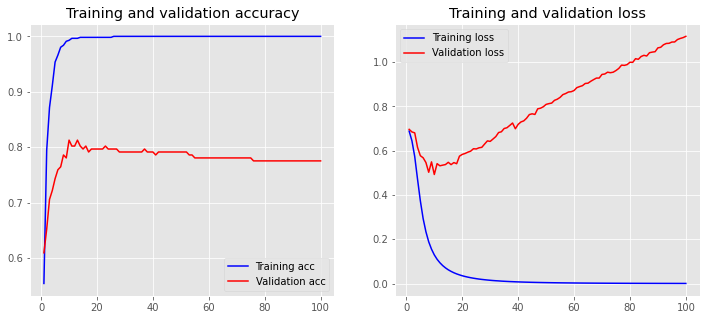

In [22]:
plot_history(history)

## Word Embedding
### One-Hot Encoding examples

In [23]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

In [25]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

### Used Keras to Tokenize our test and training data. 

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


### Display tokens for "the" "all" "sucked" and "bad". 

In [34]:
for word in ['the', 'all', 'sucked', 'bad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
sucked: 563
bad: 30


### Used Keras to pad each sentence with zeros. 

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Built sequental model and maps our data to it. 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           128750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


### Train model with .fix method. Print and plot accuracy over time. 

Training Accuracy: 1.0000
Testing Accuracy:  0.6684


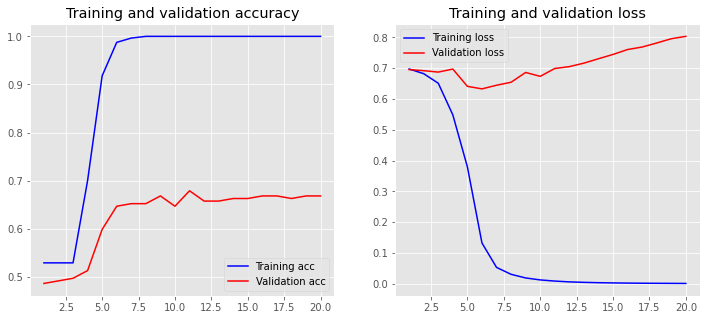

In [37]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Add layer to model with globel max/average pooling. 

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


### Train model and plot accuracy over time. 

Training Accuracy: 1.0000
Testing Accuracy:  0.7701


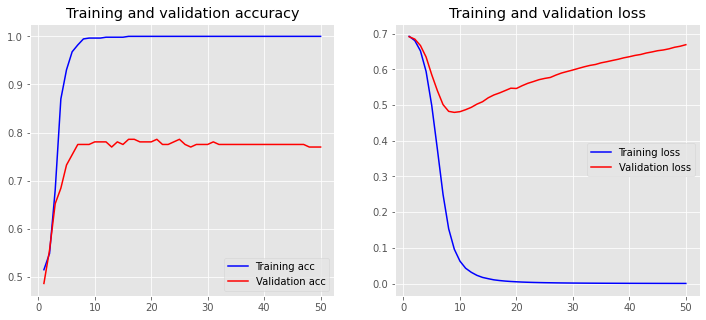

In [39]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Function that splits the lines. 

In [40]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

### runs embedding matrixs on file. 

In [46]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('data/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

### Return number of non zero vectors. 

In [47]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

### Define another sequential model.

In [48]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


### Trained and plot models accuracy over time. 

Training Accuracy: 0.7754
Testing Accuracy:  0.7487


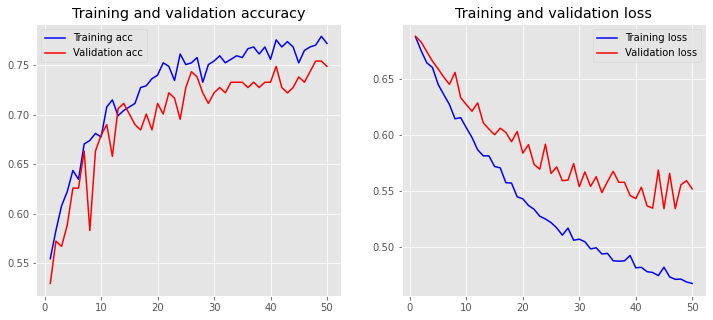

In [49]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Defined another sequential model. 

In [50]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


### Trained and plotted accuracy over time. 

Training Accuracy: 1.0000
Testing Accuracy:  0.7594


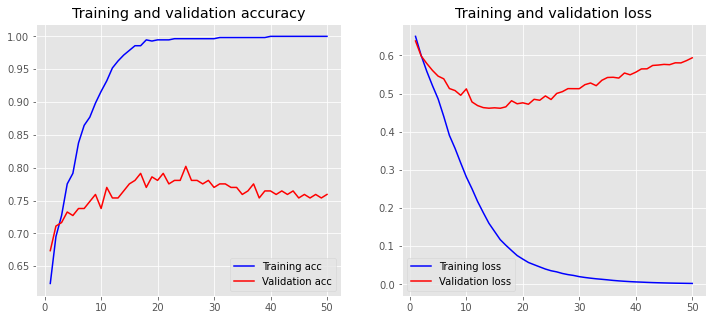

In [51]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Convolutinal Neural Networks
### Create a convolutional neural network model

In [52]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


### Trained and plot

Training Accuracy: 1.0000
Testing Accuracy:  0.7647


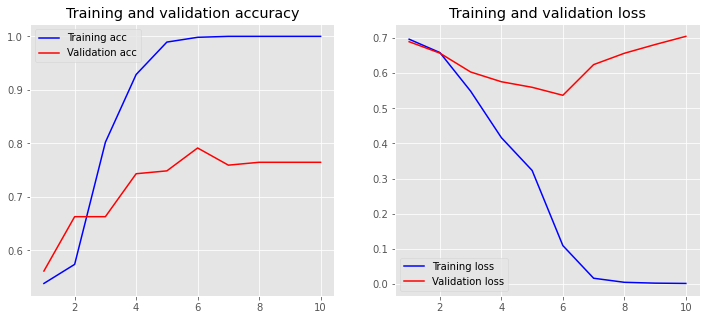

In [53]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Hyperparameter Optimization
### Used previous model but allowed for hyperparameter optimization. 

In [54]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Initial parameter grid

In [55]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

### Used random search to optimize hyperparameters, train model on Yelp, Amazon and IMDB data and print accuracy. 

In [56]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.5min finished


finished amazon; write to file and proceed? [y/n] y


Running amazon data set
Best Accuracy : 0.8185
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8341


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.5min finished


finished imdb; write to file and proceed? [y/n] y


Running imdb data set
Best Accuracy : 0.8156
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8326


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.5min finished


finished yelp; write to file and proceed? [y/n] y


Running yelp data set
Best Accuracy : 0.8185
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8297


